Protein-ligand binding: Markov model analysis of Benzamidine-Trypsin binding
------
In this notebook we will use PyEMMA to analyze the binding kinetics of Benzamidine to Trypsin using $10$ microseconds of trajectory data generated with ACEMD. This dataset is part of the [github/markovmodel/PyEMMA_IPython](https://github.com/markovmodel/PyEMMA_IPython/tree/master/applications). Other test data are also available.

This notebook is a reproduction of the original notebooks of [here](http://www.emma-project.org/v2.1/generated/trypsin_benzamidine_hmm.html) and [here](http://www.emma-project.org/latest/legacy-notebooks/applications/trypsin_benzamidine_hmm/trypsin_benzamidine_hmm.html).

## Featurization: Ligand-Protein Contact

In [1]:
import os, sys, math
import numpy as np

import pyemma
from pyemma.util.contexts import settings
from pyemma.util.statistics import confidence_interval

# for visualization of molecular structures:
import nglview
import mdtraj
from threading import Timer
from nglview.player import TrajectoryPlayer
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})

In [2]:
from pyemma import config 
config.show_progress_bars = False

In [3]:
from utils.utils import units, save_figure, index_unbound_bound, pi2dG, binding_free_energy, mfpt2kon, binding_rate, mfpt2koff, unbinding_rate

### Load data

In [4]:
indir = '../../../data/trypsin_benzamidine_hmm'
pdb =  indir+'/tryp_ben_protein.pdb'

files = []
for filename in os.listdir(indir):
    if filename.endswith('-200ns.xtc'):
        files.append(os.path.join(indir,filename))

### Featurize (Protein-ligand contact)

In [5]:
feat = pyemma.coordinates.featurizer(pdb)

In [6]:
print('First residue: {}'.format(feat.topology.residue(0)))
print('Second last residue: {}'.format(feat.topology.residue(feat.topology.n_residues - 2)))
print('Last residue: {}'.format(feat.topology.residue(feat.topology.n_residues - 1)))

First residue: ILE1
Second last residue: Ca2224
Last residue: BEN225


In [7]:
# check benzamidine recongnition residue  
print(feat.topology.residue(170))
print(feat.topology.residue(224))

ASP171
BEN225


In [8]:
# featurize ligand and protein residue contacts

n_res = 223      # number of residues (exlclude Ca residue)
lig_index = 225  # benzamidine index (with residues starting at 1)
index_arr = np.zeros((n_res,2), dtype="int")
for i in range(n_res):
    index_arr[i][0] = lig_index - 1
    index_arr[i][1] = i

In [9]:
threshold = 0.5

In [10]:
contact_feat = pyemma.coordinates.featurizer(pdb)
contact_feat.add_residue_mindist(residue_pairs=index_arr, scheme='closest-heavy', threshold=threshold)  # threshold unit: nanometer
contact_data = pyemma.coordinates.load(files, contact_feat)
labels = ['threshold\n{}'.format(threshold)]

In [11]:
contact_feat.describe()[:5]

['RES_DIST (closest-heavy) BEN225 - ILE1',
 'RES_DIST (closest-heavy) BEN225 - VAL2',
 'RES_DIST (closest-heavy) BEN225 - GLY3',
 'RES_DIST (closest-heavy) BEN225 - GLY4',
 'RES_DIST (closest-heavy) BEN225 - TYR5']

### TICA

In [12]:
lag = 10
data = contact_data

In [13]:
# TICA
#tica = pyemma.coordinates.tica(data, dim=dim, lag=lag)
tica = pyemma.coordinates.tica(data, lag=lag)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

Retained dimension:  59


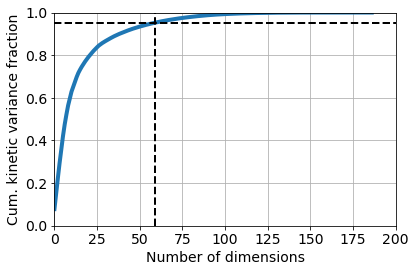

In [14]:
print('Retained dimension: ', tica.dimension())

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(tica.cumvar, linewidth=4)
ax.plot([tica.dimension(), tica.dimension()], [0, 1], color='black', ls='--', linewidth=2)
ax.plot([0, 200], [0.95, 0.95], color='black', ls='--', linewidth=2)
ax.set_xlim(0,200)
ax.set_ylim(0,1)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Cum. kinetic variance fraction')
ax.grid()
fig.tight_layout()

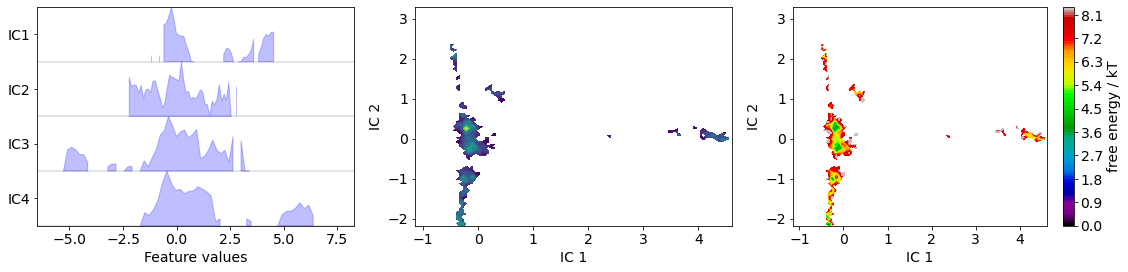

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

pyemma.plots.plot_feature_histograms(tica_concatenated[:,:4], ax=axes[0], feature_labels=['IC1', 'IC2', 'IC3', 'IC4'], ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True, cbar=False)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
#pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False, kT=0.6, cbar_label='free enegy [kcal/mol]')

for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
    #ax.set_xlim(-1,5)
    #ax.set_ylim(-3.5, 2.5)

fig.tight_layout()

### Dimension reduction and discretization

In [16]:
n_clusters = 100
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=n_clusters, max_iter=500, stride=1, fixed_seed=1)

for i in range(0,100):
    _cluster = cluster    
    cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=n_clusters, max_iter=500, stride=1, keep_data=True, clustercenters=_cluster.clustercenters)

In [17]:
# check current and previous cluster centroids (raises error if not tolerates threshold)
np.testing.assert_allclose(cluster.clustercenters, _cluster.clustercenters, rtol=1e-03, atol=1e-03)

In [18]:
dtrajs = cluster.dtrajs
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

In [19]:
Dall = np.concatenate(dtrajs)
Xall = np.vstack(data)
distogram = np.zeros(n_clusters)
for i in range(n_clusters):
    Xsub = Xall[np.where(Dall==i)[0]]
    distogram[i] = Xsub.sum() / Xsub.shape[0]

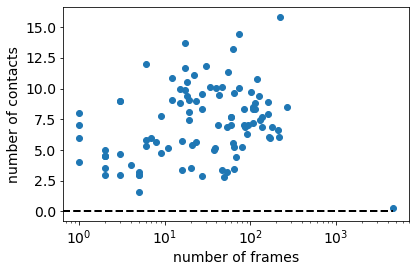

In [20]:
histogram = np.bincount(np.concatenate(cluster.dtrajs), minlength=len(cluster.clustercenters));

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(histogram, distogram)
ax.plot([0, histogram.max()], [0, 0], color='black', ls='--', linewidth=2)
ax.semilogx()
ax.set_xlabel('number of frames')
ax.set_ylabel('number of contacts')

fig.tight_layout()
#save_figure('plot_distogram.png')

In [21]:
i_micro_unbound = np.argmin(distogram)
print('Microstate of unbound index is {}'.format(i_micro_unbound))
print("Minimum # of contact: {} / Maximum # of contact: {}".format(distogram.min(), distogram.max()))

Microstate of unbound index is 0
Minimum # of contact: 0.2455193262794213 / Maximum # of contact: 15.833333333333334


### Implied timescale

In [22]:
nstates = 5
lags=[1,2,3,4,5,7,10]
nsamples = 250

In [23]:
its = pyemma.msm.timescales_hmsm(dtrajs, nstates, lags=lags, errors='bayes', nsamples=nsamples, n_jobs=-1)

/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))
/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))
/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))
/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))
/Users/kt/anaconda3/envs/pyemma/lib/python3.8/si

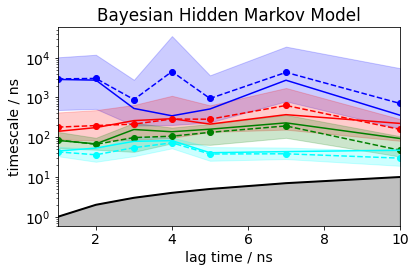

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
pyemma.plots.plot_implied_timescales(its, units='ns', dt=1)
#ax.set_ylim(1, 1000000)
ax.set_title('Bayesian Hidden Markov Model')
fig.tight_layout()

### Thermodynamic analysis

In [25]:
dG_stats = np.array([binding_free_energy(M, i_micro_unbound) for M in its.models])

>lag=1: dG_mle=-inf / pi_mle=[0. 0. 0. 1. 0.] / (i_unbound: 2, i_bound: 3)
>lag=2: dG_mle=-inf / pi_mle=[0. 0. 0. 0. 1.] / (i_unbound: 0, i_bound: 4)
Bound and unbound found in same macrostate. Bound state will be redefined.
>lag=3: dG_mle=-2.67 / pi_mle=[0.20983112 0.09044273 0.10292932 0.16942228 0.42737455] / (i_unbound: 4, i_bound: 0)
Bound and unbound found in same macrostate. Bound state will be redefined.
>lag=4: dG_mle=-2.68 / pi_mle=[0.08470714 0.47691495 0.23678727 0.09217257 0.10941807] / (i_unbound: 1, i_bound: 2)
Bound and unbound found in same macrostate. Bound state will be redefined.
>lag=5: dG_mle=-2.90 / pi_mle=[0.1875709  0.0859906  0.38782223 0.06172123 0.27689505] / (i_unbound: 2, i_bound: 4)
>lag=7: dG_mle=-inf / pi_mle=[1. 0. 0. 0. 0.] / (i_unbound: 3, i_bound: 0)
Bound and unbound found in same macrostate. Bound state will be redefined.
>lag=10: dG_mle=-2.92 / pi_mle=[0.06456308 0.06837381 0.45088013 0.08490782 0.33127517] / (i_unbound: 2, i_bound: 4)


/Users/kt/work/repo/pyemma_examples/notebooks/trypsin_benzamidine/bhmm/utils/utils.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  delta_g = -0.6 * np.log(pi[i_bound]/pi[i_unbound])  # dG in kcal/mol


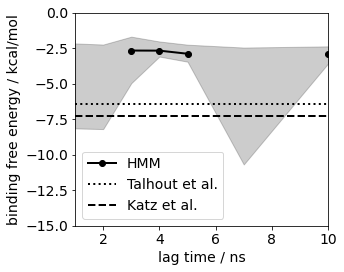

In [26]:
plt.figure(figsize=(5,4))

# plot binding affinities
plt.plot(its.lags, dG_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
plt.fill_between(its.lags, dG_stats[:, 1], dG_stats[:, 2], alpha=0.2, color='black')
# experimental reference: 6.4 kcal/mold from Talhout R, Engberts JBFN. Eur J Biochem. 2001;268(6):1554–1560
plt.plot(its.lags, -6.4*np.ones(len(its.lags)), linewidth=2, linestyle='dotted', color='black', label='Talhout et al.')
# experimental reference: 7.3 kcal/mold from 66. Katz BA, Elrod K, Luong C, Rice MJ, Mackman RL, Sprengeler PA, Spencer J, Hataye J, Janc J, Link J, Litvak J, Rai R, Rice K, Sideris S, Verner E, Young W. Journal of Molecular Biology. 2001;307(5):1451–1486.
plt.plot(its.lags, -7.3*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Katz et al.')

plt.xlim(1, 10)
plt.xlabel('lag time / ns')
plt.ylim(-15, 0)
plt.ylabel('binding free energy / kcal/mol')
plt.legend(loc=3, fontsize=14)

plt.tight_layout()
#save_figure('dG.png')

Let's look into more details about the model

In [27]:
#for m in its.models:
#    print(m)

In [28]:
bhmm = its.models[2]
print(bhmm)

BayesianHMSM(conf=0.95, connectivity=None, dt_traj='1 step', init_hmsm=None,
       lag=3, mincount_connectivity=0.2, nsamples=250, nstates=5,
       observe_nonempty=True, p0_prior='mixed', reversible=True,
       separate=None, show_progress=False, stationary=False,
       store_hidden=False, stride=3, transition_matrix_prior='mixed')


In [29]:
bhmm.stationary_distribution

array([0.20983112, 0.09044273, 0.10292932, 0.16942228, 0.42737455])

In [30]:
i_macro_bound = np.argmax(bhmm.stationary_distribution)
i_macro_unbound = np.argmax(bhmm.observation_probabilities[:, i_micro_unbound])
print(i_micro_unbound, i_macro_bound, i_macro_unbound)

0 4 4


In [31]:
bhmm.metastable_sets

[array([ 2,  4,  7, 15, 20, 24, 50, 55, 56, 57, 63, 64, 69, 77, 82, 91, 92]),
 array([ 3, 10, 16, 58, 62, 75, 79, 85]),
 array([ 5, 12, 21, 28, 37, 40, 47, 61, 66, 68, 78, 83, 88, 94]),
 array([ 1,  8, 11, 19, 25, 34, 42, 43, 44, 48, 65, 71, 76, 90]),
 array([ 0,  6,  9, 13, 14, 17, 18, 22, 23, 26, 27, 29, 30, 31, 32, 33, 35,
        36, 38, 39, 41, 45, 46, 49, 51, 52, 53, 54, 59, 60, 67, 70, 72, 73,
        74, 80, 81, 84, 86, 87, 89, 93, 95])]

In [32]:
np.shape(bhmm.observation_probabilities)

(5, 96)

In [33]:
bhmm.observation_probabilities[:, 0]

array([5.11388099e-34, 4.90189961e-15, 6.16748722e-24, 7.82486902e-26,
       7.02864655e-01])

In [34]:
#bhmm.observation_probabilities

In [35]:
#np.sum(bhmm.observation_probabilities[1, :])

### Kinetic analysis

In [36]:
kon_stats = np.array([binding_rate(M, i_micro_unbound) for M in its.models])

/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/mean_first_passage_time.py:124: RuntimeWarning: invalid value encountered in true_divide
  muX = nuX / np.sum(nuX)


Bound and unbound found in same macrostate. Bound state will be redefined.
Bound and unbound found in same macrostate. Bound state will be redefined.
Bound and unbound found in same macrostate. Bound state will be redefined.
Bound and unbound found in same macrostate. Bound state will be redefined.


In [37]:
koff_stats = np.array([unbinding_rate(M, i_micro_unbound) for M in its.models])

LinAlgError: Matrix is singular.

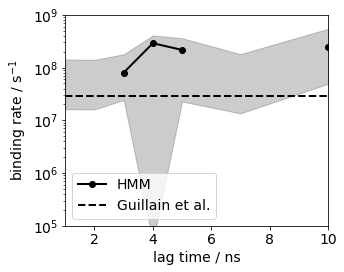

In [38]:
plt.figure(figsize=(5,4))

# plot binding rates
plt.plot(its.lags, kon_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
plt.fill_between(its.lags, kon_stats[:, 1], kon_stats[:, 2], alpha=0.2, color='black')
# experimental values from Guillain, F. & Thusius, D. Use of proflavine as an indicator in temperature- jump studies of the binding of a competitive inhibitor to trypsin. J. Am. Chem. Soc. 92, 5534–5536 (1970).
# experimental k_on:  2.9x10**7 mol-1 sec-1'
plt.plot(its.lags, 2.9*1e7*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Guillain et al.')

plt.legend(loc=3, fontsize=14)
plt.xlim(1, 10)
plt.xlabel('lag time / ns')
plt.ylim(1e5, 1e9)
plt.ylabel('binding rate / s$^{-1}$')
plt.semilogy()

plt.tight_layout()
#save_figure('k_on.png')

In [39]:
plt.figure(figsize=(5,4))

# plot binding rates
plt.plot(its.lags, koff_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
plt.fill_between(its.lags, koff_stats[:, 1], koff_stats[:, 2], alpha=0.2, color='black')
# experimental
#print 'k_off experimental = 6*10**2 sec-1'
plt.plot(its.lags, 600.0*np.ones(len(its.lags)), linewidth=2, linestyle='dashed', color='black', label='Guillain et al.')

plt.xlim(1, 10)
plt.xlabel('lag time / ns')
plt.ylim(1e-2, 1e7)
plt.ylabel('dissociation rate / s$^{-1}$')
plt.legend(loc=2, fontsize=14)
plt.semilogy()

plt.tight_layout()
#save_figure('k_off.png')

NameError: name 'koff_stats' is not defined

<Figure size 360x288 with 0 Axes>

### Chapman-Kolmogorov Test

Now we want to have a closer look on the five-state model and inspect the structures and binding pathways. We could estimate the HMM at lag=3 using msm.estimate_hidden_markov_model(dtrajs, 5, 2), but that’s not even needed because we have estimated that model already as the second model of our implied timescales scan:

In [40]:
bhmm = its.models[2]
print(bhmm)

BayesianHMSM(conf=0.95, connectivity=None, dt_traj='1 step', init_hmsm=None,
       lag=3, mincount_connectivity=0.2, nsamples=250, nstates=5,
       observe_nonempty=True, p0_prior='mixed', reversible=True,
       separate=None, show_progress=False, stationary=False,
       store_hidden=False, stride=3, transition_matrix_prior='mixed')


In [41]:
ck = bhmm.cktest(mlags=5, err_est=True)

/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


04-02-22 20:17:58 pyemma.msm.estimators.bayesian_hmsm.BayesianHMSM[210] WARNING  Ignored error during estimation: index 96 is out of bounds for axis 1 with size 96


/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


04-02-22 20:18:00 pyemma.msm.estimators.bayesian_hmsm.BayesianHMSM[210] WARNING  Ignored error during estimation: index 96 is out of bounds for axis 1 with size 96
04-02-22 20:18:01 pyemma.msm.estimators.bayesian_hmsm.BayesianHMSM[210] WARNING  Ignored error during estimation: index 96 is out of bounds for axis 1 with size 96


/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/msmtools/analysis/dense/pcca.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


04-02-22 20:18:02 pyemma.msm.estimators.bayesian_hmsm.BayesianHMSM[210] WARNING  Ignored error during estimation: index 96 is out of bounds for axis 1 with size 96


/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


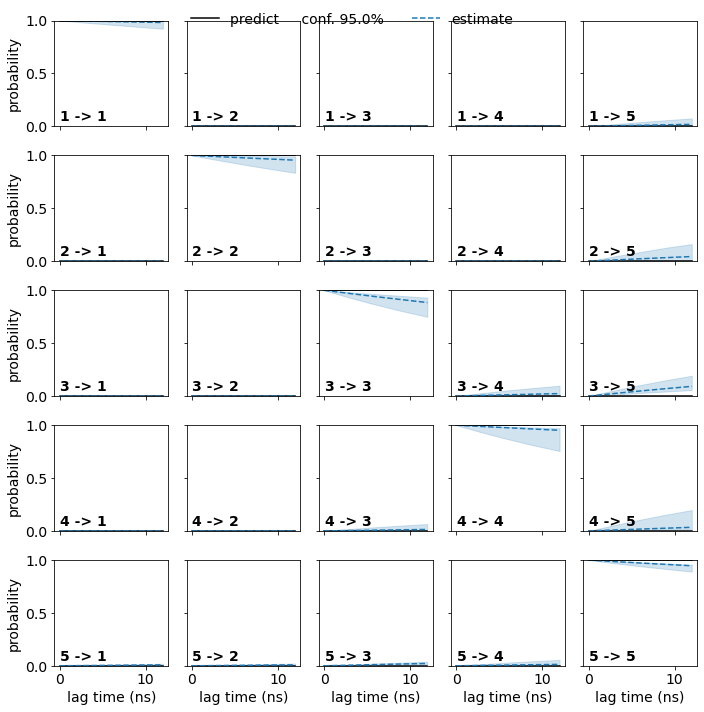

In [42]:
fig, axes = pyemma.plots.plot_cktest(ck, dt=1, units='ns')        
#for i in range(5):
#    for j in range(5):
#        if i==j:
#            axes[i, i].set_ylim(0.9, 1.0)
#        else:
#            axes[i, j].set_ylim(0.0, 0.1)
fig.tight_layout()

#### save metastable states

In [43]:
meta_samples = bhmm.sample_by_observation_probabilities(100)

In [44]:
outfiles = ['./data/hmm1_100samples.xtc',
            './data/hmm2_100samples.xtc',
            './data/hmm3_100samples.xtc',
            './data/hmm4_100samples.xtc',
            './data/hmm5_100samples.xtc']

In [45]:
inp = pyemma.coordinates.source(files, contact_feat)
pyemma.coordinates.save_trajs(inp, meta_samples, outfiles=outfiles)

['./data/hmm1_100samples.xtc',
 './data/hmm2_100samples.xtc',
 './data/hmm3_100samples.xtc',
 './data/hmm4_100samples.xtc',
 './data/hmm5_100samples.xtc']

In [46]:
#Image(filename='./figs/hmm_allstates.png')

### Network analysis

In order to make a nice illustration of the transition network, let’s find out which HMM state is the unbound one (we define it by the metastable state containing the dissociated cluster, i.e. the cluster without Trypsin-Benzamidine contacts), and bound one (defined by the state with highest probability):

In [47]:
i_meta_unbound = np.argmax(bhmm.metastable_memberships[i_micro_unbound])
i_meta_bound = np.argmax(bhmm.stationary_distribution)
print('Unbound state: {}'.format(i_meta_unbound))
print('Bound state: {}'.format(i_meta_bound))

Unbound state: 4
Bound state: 4


In [48]:
pos=np.array([[3,3],[4.25,0],[0,1],[1.75,0],[6,1.0]])
state_colors = ['green', 'blue', 'yellow', 'cyan', 'purple']
state_sizes = bhmm.stationary_distribution**(0.25)
print('probabilities: {}'.format(bhmm.stationary_distribution))
print('plotting sizes: {}'.format(state_sizes))

probabilities: [0.20983112 0.09044273 0.10292932 0.16942228 0.42737455]
plotting sizes: [0.6768111  0.54839491 0.56641504 0.64156791 0.80854122]


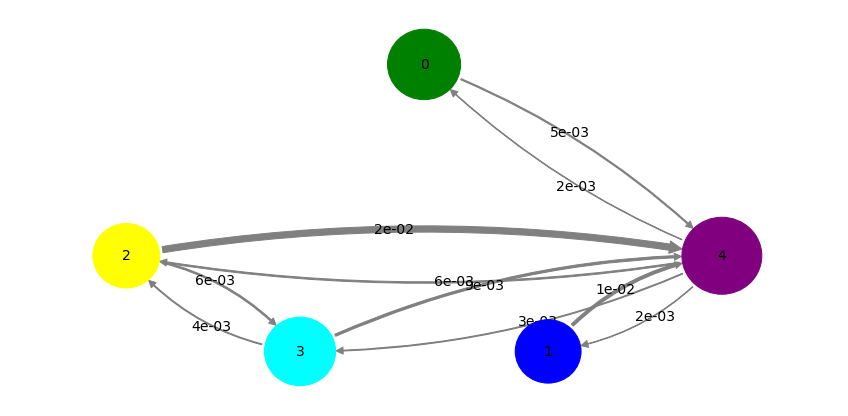

In [49]:
fig, pos = pyemma.plots.plot_markov_model(bhmm, pos=pos, state_sizes=state_sizes, state_colors=state_colors)

plt.tight_layout()
#save_figure('network.png')

Finally, we conduct transition path theory in the MSM formulation. Since the HMM is at the same time an MSM amongst its metastable states, we can just throw the HMM object into the TPT function. We have to define two end-states of the transition, and here we just the unbound and bound states.

In [50]:
tpt = pyemma.msm.tpt(bhmm, [i_meta_unbound], [i_meta_bound])

ValueError: Sets A and B have to be disjoint

In [51]:
pyemma.plots.plot_flux(tpt, pos=pos, state_sizes=state_sizes, state_colors=state_colors, show_committor=False)
plt.tight_layout()
#save_figure('network_flux.png')

NameError: name 'tpt' is not defined

### Test other MSM estimators